In [3]:
# utils
import os
import subprocess
import numpy as np
import keras

# for audio and video manipulation
import moviepy.editor as mp
import cv2
import librosa
from joblib import load
import tkinter as tk

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



In [4]:
haar_path = 'haarcascade_frontalface_default.xml'
parameters_path = 'RAVDESS_audio/std_scaler.bin'
models_video_path = "models/video/"
models_audio_path = "models/audio/"
emotions_tras = {1:1, 2:4, 3:5, 4:0, 5:3, 6:2, 7:6}
emotions = {0:'angry', 1:'calm', 2:'disgust', 3:'fear', 4:'happy', 5:'sad', 6:'surprise'}
height_targ = 112
width_targ = 112
sr = 48000
# skip = 3

In [5]:
filename = "/content/emilia.mp4"
label = "angry"
print(f"Selected file: {filename}")
print(f"Ground truth label: {label}")


Selected file: /content/emilia.mp4
Ground truth label: angry


In [14]:
cap = cv2.VideoCapture(filename)
haar_cascade = cv2.CascadeClassifier(haar_path)
frames = []
count = 0
skip = 3

# Loop through all frames
while True:
    # Capture frame
    ret, frame = cap.read()
    if (count % skip == 0 and count > 20):
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # detect and crop face
        faces = haar_cascade.detectMultiScale(frame, scaleFactor=1.12, minNeighbors=9)
        if len(faces) != 1:
            continue
        for (x, y, w, h) in faces:
            face = frame[y:y + h, x:x + w]

        face = cv2.resize(face, (height_targ+10, width_targ+10))
        face = face[5:-5, 5:-5]
        face = face/255.
        frames.append(face)
    count += 1

frames = np.array(frames)
num_frames = len(frames)
labels = [label] * num_frames
print('shape frames:', frames.shape)

shape frames: (112, 112, 112)


In [15]:
import numpy as np
import soundfile as sf
import subprocess

# Convert to WAV
subprocess.run([
    "ffmpeg", "-i", filename, "-ac", "2", "-ar", str(sr), "temp.wav", "-y"
], capture_output=True)

# load full audio
audio_full, file_sr = sf.read("temp.wav")
if audio_full.ndim == 2:
    audio_full = audio_full[:, 0]

# load scaler
scaler = load(parameters_path)

# window parameters for 3-second chunks
window_size = 143872
hop_size = window_size

# Process audio in 3-second windows
audio_mels = []
current_sample = 0

while current_sample + window_size <= len(audio_full):
    # Extract 3-second window
    audio_window = audio_full[current_sample:current_sample + window_size]

    # Compute mel spectrogram
    mel = librosa.power_to_db(
        librosa.feature.melspectrogram(
            y=audio_window,
            sr=sr,
            n_fft=1024,
            hop_length=512,
            n_mels=128,
            fmin=50,
            fmax=24000
        )
    )

    # Transform with scaler
    mel = scaler.transform(mel)
    mel = np.expand_dims(mel, axis=2)
    mel = np.expand_dims(mel, axis=0)

    audio_mels.append(mel)

    # Move to next 3-second window
    current_sample += hop_size

print(f"Created {len(audio_mels)} audio windows for {num_frames} video frames")


https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



Created 4 audio windows for 112 video frames


In [16]:
models_list = os.listdir(models_video_path)

acc = [float(model.split('[')[1].split(']')[0]) for model in models_list]
idx = acc.index(max(acc))                                                       # index of best model

model_video = keras.models.load_model(models_video_path + models_list[idx])
# model_video.summary()

  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

  warnings.warn(



In [17]:
models_list = os.listdir(models_audio_path)
model_audio = keras.models.load_model(models_audio_path + models_list[0])
# model_audio.summary()

In [18]:
pred = model_video.predict(frames)
print(pred.shape)
pred_video = pred
print(pred_video.argmax())

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step
(112, 7)
756


In [19]:
pred_audio_list = []
for mel in audio_mels:
    pred = model_audio.predict(mel, verbose=0)
    pred_audio_list.append(pred[0])

pred_audio = np.array(pred_audio_list)
# pred_audio
print(pred_audio.shape)

(4, 7)


In [20]:
# expand audio predictions to match video frame count
num_audio = len(pred_audio)
num_video = len(pred_video)
print(num_audio)
print(num_video)
x_audio = np.linspace(0, 1, num_audio)
x_video = np.linspace(0, 1, num_video)

pred_audio_expanded = np.zeros_like(pred_video)
for j in range(pred_audio.shape[1]):
    pred_audio_expanded[:, j] = np.interp(x_video, x_audio, pred_audio[:, j])

# calc fused predictions
pred_fused = (pred_video + pred_audio_expanded) / 2

# check shapes
print(f"pred_video shape: {pred_video.shape}")
print(f"pred_audio_expanded shape: {pred_audio_expanded.shape}")
print(f"pred_fused shape: {pred_fused.shape}")  # Should be (num_frames, 7)

4
112
pred_video shape: (112, 7)
pred_audio_expanded shape: (112, 7)
pred_fused shape: (112, 7)


In [21]:
labels = [label] * num_frames
print(labels)
print(pred_fused)

['angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 

**make audio-visual graph**

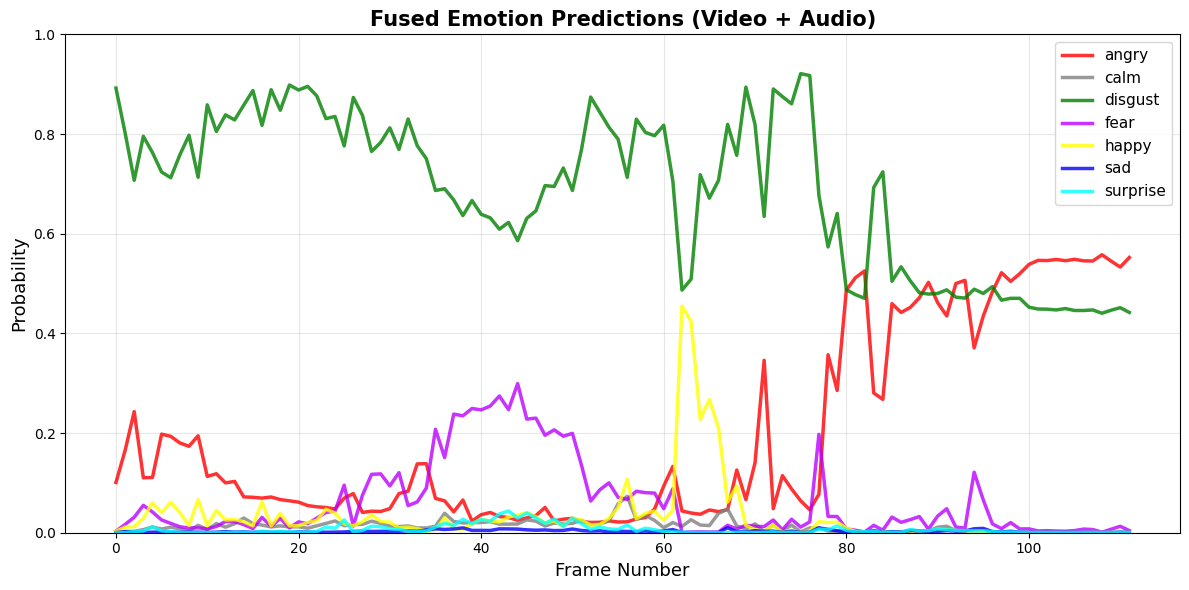

Total frames: 112


In [22]:
# output graph video, audio, video + audio
import matplotlib.pyplot as plt
import numpy as np

frame_indices = np.arange(len(pred_video))

# Emotion colors
emotion_colors = {
    0: "#FF0000",      # angry
    1: "#808080",     # calm
    2: "#008000",   # disgust
    3: "#BB00FF",   # fear
    4: "#FFFF00",     # happy
    5: "#0000FF",     # sad
    6: "#00FFFF"      # surprise
}

# Create single plot
plt.figure(figsize=(12, 6))

# Plot all 7 emotion probability lines
for emo_idx in range(7):
    plt.plot(frame_indices, pred_fused[:, emo_idx],
            label=emotions[emo_idx],
            color=emotion_colors[emo_idx],
            linewidth=2.5,
            alpha=0.8)

plt.xlabel('Frame Number', fontsize=13)
plt.ylabel('Probability', fontsize=13)
plt.ylim([0, 1])
plt.title('Fused Emotion Predictions (Video + Audio)', fontsize=15, fontweight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(axis='both', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
fused_overall = np.argmax(np.mean(pred_fused, axis=0))
print(f"Total frames: {len(pred_video)}")
